# 1. Initializations and Dataset Download with google colab

In [ ]:
!pip install transformers --quiet
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasciencetool/covid19-vaccine-tweets-with-sentiment-annotation")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: cookiett
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/datasciencetool/covid19-vaccine-tweets-with-sentiment-annotation


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mv covid19-vaccine-tweets-with-sentiment-annotation /content/drive/MyDrive/Data

**Using google colab**

- label: negative 1, neutral 2, positive 3


```
drive/MyDrive/Data/covid19-vaccine-tweets-with-sentiment-annotation/
├── covid-19_vaccine_tweets_with_sentiment.csv (6000 rows)
tweet_id	        label	tweet_text
1360342002961940483	1	4,000 a day dying from the so called Covid-19 “vaccine” @DailyBeast reports. #vaccine #PfizerVaccine #Moderna
1382896334886248448	2	Pranam message for today manifested in Dhyan by @meenapranam #truth #love #karm #light #nature #consciousness #FridayThoughts #fridaymorning #CoronavirusIndia #COVID19India #?????_???????? #navratri #Thane #AmbedkarJayanti2021 #ModiJi #NarendraModi #SecondCOVIDWave #Covaxin https://t.co/bQNoMVowJg
1375673411846873089	2	Hyderabad-based ?@BharatBiotech? has sought funds from the government to ramp up production of its indigenously developed Covid-19 vaccine, #Covaxin .
The company has written to the ??@DBTIndia? seeking Rs 100 crore to ramp up.
...
```

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_scheduler
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


# 2. Dataset

In [4]:
data_dir = '/content/drive/MyDrive/Data/covid19-vaccine-tweets-with-sentiment-annotation/covid-19_vaccine_tweets_with_sentiment.csv'
data_df = pd.read_csv(data_dir, encoding='latin1') # Or 'iso-8859-1', 'cp1252'
# encoding='latin1'을 넣어야 에러 없음

print("Data shape is: ", data_df.shape)
print()
data_df.head()

Data shape is:  (6000, 3)



,tweet_id,label,tweet_text
0,1.360342e+18,1,"4,000 a day dying from the so called Covid-19 ..."
1,1.382896e+18,2,Pranam message for today manifested in Dhyan b...
2,1.375673e+18,2,Hyderabad-based ?@BharatBiotech? has sought fu...
3,1.381311e+18,1,"Confirmation that Chinese #vaccines ""dont hav..."
4,1.362166e+18,3,"Lab studies suggest #Pfizer, #Moderna vaccines..."


**Remove 'tweet_id' column'**

tweet_id에 대한 디테일한 내용은 필요없기 때문에 링크 자체는 학습시킬 필요가 없다.

In [5]:
data_df = data_df[["tweet_text","label"]]

print("Data shape is: ", data_df.shape)
data_df.head()

Data shape is:  (6000, 2)


,tweet_text,label
0,"4,000 a day dying from the so called Covid-19 ...",1
1,Pranam message for today manifested in Dhyan b...,2
2,Hyderabad-based ?@BharatBiotech? has sought fu...,2
3,"Confirmation that Chinese #vaccines ""dont hav...",1
4,"Lab studies suggest #Pfizer, #Moderna vaccines...",3


# 3. Data Spliting

- Clean train/val/test split with stratification (70/15/15)

In [6]:
# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(np.array(data_df["tweet_text"]), np.array(data_df["label"]), test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

print("Training set is: ", X_train.shape[0], " rows which is ", round(X_train.shape[0]/data_df.shape[0],4)*100, "%")
print("Validation set is: ",X_val.shape[0], " rows which is ", round(X_val.shape[0]/data_df.shape[0],4)*100, "%")
print("Testing set is: ",X_test.shape[0], " rows which is ", round(X_test.shape[0]/data_df.shape[0],4)*100, "%")

Training set is:  4200  rows which is  70.0 %
Validation set is:  900  rows which is  15.0 %
Testing set is:  900  rows which is  15.0 %


# 4. Initialize tokenizer and model

- Using RoBERTa model

In [7]:
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

  roberta-base model has three `problem_type` options: `single_label_classification`, `multi_label_classification`, and `regression`.

 - `num_labels`: This argument determines the number of output classes your model will predict. Since you have 3 labels (negative, neutral, positive), you need to set `num_labels=3`. By doing this, the model will have three output neurons, one for each class.
 - `problem_type`: You are using "single_label_classification" which is correct because each tweet should belong to only one sentiment category (negative, neutral, or positive).
    - `multi_label_classification`: This option is used when a single input can belong to multiple classes. For example, if you were classifying news headlines into multiple categories (e.g., politics, sports, entertainment), you would use this option.
    - `regression`: This option is used when you want to predict a continuous value. For example, if you were predicting the price of a house, you would use this option.

In [8]:
# Load model with specified number of labels
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    problem_type="single_label_classification"
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
model = model.to(device) # Move model to device

# 5. Dataset & Transforms

In [10]:
class TextDataset(Dataset):
    """Modern dataset implementation for text classification"""
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx] - 1 # Map labels from 1, 2, 3 to 0, 1, 2

        # Use batch_encode_plus for more efficient tokenization
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors=None  # Return as python lists instead of tensors
            # return_tensors='pt'  # Return as PyTorch tensors
        )

        # Convert to tensors here
        item = {
            'input_ids': torch.tensor(encoding['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(encoding['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.long)
        }

        return item

In [11]:
# Prepare datasets
train_dataset = TextDataset(X_train, y_train, tokenizer)
val_dataset = TextDataset(X_val, y_val, tokenizer)
test_dataset = TextDataset(X_test, y_test, tokenizer)

# 6. Create dataloaders

In [12]:
# Create dataloaders
batch_size = 16  # Smaller batch size for better generalization

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size
)

# 7. Fine-tuning setup

In [13]:
# Unfreeze only the last few layers of the transformer
# This is a compromise between feature extraction and full fine-tuning
for param in model.base_model.parameters():
    param.requires_grad = False

# Unfreeze the last 2 transformer layers
for layer in model.base_model.encoder.layer[-2:]:
    for param in layer.parameters():
        param.requires_grad = True

# 8. Setup optimizer with weight decay

In [14]:
# AdamW includes weight decay for regularization
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=2e-5,  # Lower learning rate for fine-tuning
    weight_decay=0.01  # Add weight decay for regularization
)

# 9. Learning rate scheduler with warmup

In [15]:
# Unfreeze the classifier layer
for param in model.classifier.parameters():
    param.requires_grad = True

num_epochs = 5  # Fewer epochs with better training regime
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    name="linear",  # Linear scheduler with warmup
    optimizer=optimizer,
    num_warmup_steps=0.1 * num_training_steps,  # 10% warmup
    num_training_steps=num_training_steps
)

# 10. Training loop

In [18]:
def train_epoch(model, dataloader, optimizer, scheduler, device):
    """Train for one epoch (multi-class version)"""
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    # Show progress bar during training
    progress_bar = tqdm(dataloader, desc="Training")

    for batch in progress_bar:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # 1. Do the Forward pass
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # 2. Calculate the loss
        loss = F.cross_entropy(logits, labels.view(-1))

        # 3. Backward pass
        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step() # Update weights
        scheduler.step() # Update learning rate

        # Prediction and accuracy
        preds = torch.argmax(logits, dim=-1)
        correct_predictions += (preds == labels).sum().item()
        total_loss += loss.item()
        total_predictions += labels.size(0)

        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item(),
                                 'accuracy': correct_predictions / total_predictions})

    # Calculate final metrics
    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions

    return avg_loss, accuracy

In [21]:
def evaluate(model, dataloader, device):
    """Evaluate the model (multi-class version)"""
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.inference_mode():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # 1. Do the Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            # 2. Calculate the loss
            loss = F.cross_entropy(logits, labels.view(-1))
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=-1)
            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = total_loss / len(dataloader)
    all_predictions = np.array(all_predictions).flatten()
    all_labels = np.array(all_labels).flatten()
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='weighted', pos_label=1
    )
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

```
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_predictions, average='binary', pos_label=1
)
```

You're using `average='binary'` which is suitable for binary classification (two classes). However, your task is a multi-class classification problem with three sentiment labels (negative, neutral, positive). This is why you're getting the ValueError: Target is multiclass but `average='binary'`.

Solution:

Change `average='binary'` to one of the options suitable for multi-class classification: 'micro', 'macro', or 'weighted'.

- `'micro'`: Calculates metrics globally by counting the total true positives, false negatives, and false positives.
- `'macro'`: Calculates metrics for each label and finds their unweighted mean. This does not take label imbalance into account.
- `'weighted'`: Calculates metrics for each label and finds their average weighted by support (the number of true instances for each label). This accounts for label imbalance.

In [22]:
print(f"Starting training for {num_epochs} epochs...")

# Initialize metrics tracking
train_metrics = {'loss': [], 'accuracy': []}
val_metrics = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Train for one epoch
    train_loss, train_acc = train_epoch(
        model, train_dataloader, optimizer, lr_scheduler, device
    )

    # Evaluate on validation set
    val_results = evaluate(model, val_dataloader, device)

    # Store metrics
    train_metrics['loss'].append(train_loss)
    train_metrics['accuracy'].append(train_acc)

    val_metrics['loss'].append(val_results['loss'])
    val_metrics['accuracy'].append(val_results['accuracy'])
    val_metrics['precision'].append(val_results['precision'])
    val_metrics['recall'].append(val_results['recall'])
    val_metrics['f1'].append(val_results['f1'])

    # Print metrics
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_results['loss']:.4f}, Val Accuracy: {val_results['accuracy']:.4f}")
    print(f"Val Precision: {val_results['precision']:.4f}, Val Recall: {val_results['recall']:.4f}, Val F1: {val_results['f1']:.4f}")
    print("="*50)

Starting training for 5 epochs...
Epoch 1/5


Training:   0%|          | 0/263 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.6389, Train Accuracy: 0.7360
Val Loss: 0.5603, Val Accuracy: 0.7622
Val Precision: 0.7473, Val Recall: 0.7622, Val F1: 0.7407
Epoch 2/5


Training:   0%|          | 0/263 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.5669, Train Accuracy: 0.7679
Val Loss: 0.5569, Val Accuracy: 0.7733
Val Precision: 0.7627, Val Recall: 0.7733, Val F1: 0.7590
Epoch 3/5


Training:   0%|          | 0/263 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.5334, Train Accuracy: 0.7843
Val Loss: 0.5298, Val Accuracy: 0.7811
Val Precision: 0.7780, Val Recall: 0.7811, Val F1: 0.7794
Epoch 4/5


Training:   0%|          | 0/263 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.5141, Train Accuracy: 0.7864
Val Loss: 0.5320, Val Accuracy: 0.7789
Val Precision: 0.7762, Val Recall: 0.7789, Val F1: 0.7773
Epoch 5/5


Training:   0%|          | 0/263 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.5094, Train Accuracy: 0.7826
Val Loss: 0.5320, Val Accuracy: 0.7789
Val Precision: 0.7762, Val Recall: 0.7789, Val F1: 0.7773


# 11. Plot metrics

In [23]:
def plot_metrics(train_metrics, val_metrics):
    """Plot training and validation metrics"""
    epochs = range(1, len(train_metrics['loss']) + 1)

    # Plot loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_metrics['loss'], 'b-', label='Training Loss')
    plt.plot(epochs, val_metrics['loss'], 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_metrics['accuracy'], 'b-', label='Training Accuracy')
    plt.plot(epochs, val_metrics['accuracy'], 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

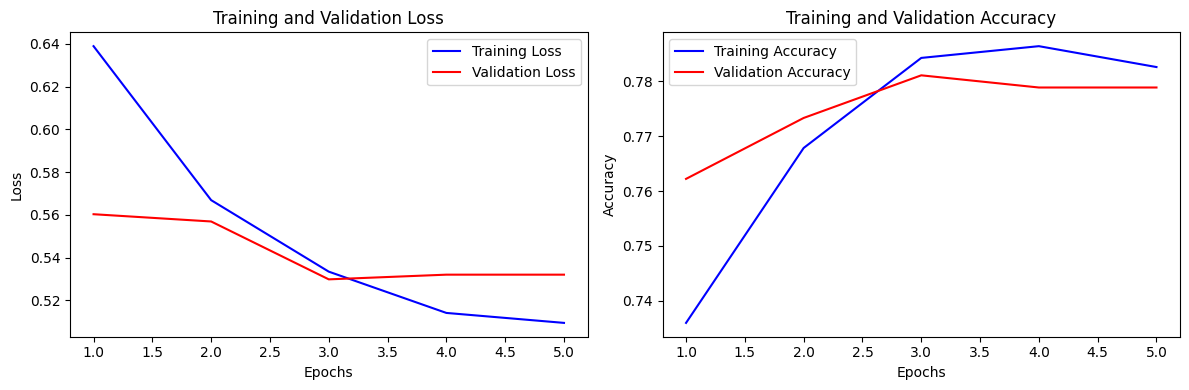

In [24]:
plot_metrics(train_metrics, val_metrics)

# 12. Evaluate on test set

In [25]:
print("Evaluating on test set...")
test_results = evaluate(model, test_dataloader, device)
print(f"Test Accuracy: {test_results['accuracy']:.4f}")
print(f"Test Precision: {test_results['precision']:.4f}")
print(f"Test Recall: {test_results['recall']:.4f}")
print(f"Test F1: {test_results['f1']:.4f}")

Evaluating on test set...


Evaluating:   0%|          | 0/57 [00:00<?, ?it/s]

Test Accuracy: 0.7533
Test Precision: 0.7430
Test Recall: 0.7533
Test F1: 0.7438


# 13. Save model

In [26]:
model_save_path = "roberta_covid19_tweet_model"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to roberta_covid19_tweet_model


In [27]:
!mv roberta_covid19_tweet_model /content/drive/MyDrive/Data

# 14. Load and Inference model

In [ ]:
import zipfile

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Data/roberta_covid19_tweet_model.zip', 'r') # 압축 파일(zip file) 읽기
zip_ref.extractall('/content/drive/MyDrive/Data/') # 압출 파일을 풀어서 지정한 폴더(예: Data 폴더)에 저장
zip_ref.close()

In [28]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_dir = "/content/drive/MyDrive/Data/roberta_covid19_tweet_model"

def inference(text, model_dir=model_dir):
    """Load model and tokenizer from disk and predict sarcasm for a single text (multi-class version)."""

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    model = model.to(device)
    model.eval()

    # Tokenize input
    encoding = tokenizer(
        text,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.inference_mode():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)
        pred_class = torch.argmax(probs, dim=-1).item()

        # Map predicted class to sentiment label
        sentiment_labels = {0: "negative", 1: "neutral", 2: "positive"}
        predicted_sentiment = sentiment_labels[pred_class]

        print(f"Text: {text}")
        print(f"Predicted Sentiment: {predicted_sentiment}")
        print(f"Class Probabilities: {probs[0].tolist()}") # Print probabilities for all classes

    return pred_class, probs[0].tolist()  # Return predicted class and probabilities

In [30]:
print("\n--- Inference Example ---")
test_text = "Oh great, another rainy day. Just what I needed!"
pred_class, probs = inference(test_text)
print(f"Predicted Class: {pred_class}")
print(f"Probabilities: {probs}")


--- Inference Example ---
Text: Oh great, another rainy day. Just what I needed!
Predicted Sentiment: positive
Class Probabilities: [0.01650213822722435, 0.2582216262817383, 0.7252762317657471]
Predicted Class: 2
Probabilities: [0.01650213822722435, 0.2582216262817383, 0.7252762317657471]


In [31]:
# Example 1: Positive sentiment
test_text1 = "I'm so excited to get vaccinated! It's a step towards normalcy."
pred_class1, probs1 = inference(test_text1)
print(f"Predicted Class: {pred_class1}")
print(f"Probabilities: {probs1}")

# Example 2: Negative sentiment
test_text2 = "This vaccine rollout is a complete disaster. I'm so frustrated."
pred_class2, probs2 = inference(test_text2)
print(f"Predicted Class: {pred_class2}")
print(f"Probabilities: {probs2}")

# Example 3: Neutral sentiment
test_text3 = "The government has announced new guidelines for vaccine distribution."
pred_class3, probs3 = inference(test_text3)
print(f"Predicted Class: {pred_class3}")
print(f"Probabilities: {probs3}")

Text: I'm so excited to get vaccinated! It's a step towards normalcy.
Predicted Sentiment: positive
Class Probabilities: [0.0007018691394478083, 0.031867556273937225, 0.967430591583252]
Predicted Class: 2
Probabilities: [0.0007018691394478083, 0.031867556273937225, 0.967430591583252]
Text: This vaccine rollout is a complete disaster. I'm so frustrated.
Predicted Sentiment: negative
Class Probabilities: [0.44860297441482544, 0.36645492911338806, 0.1849420815706253]
Predicted Class: 0
Probabilities: [0.44860297441482544, 0.36645492911338806, 0.1849420815706253]
Text: The government has announced new guidelines for vaccine distribution.
Predicted Sentiment: neutral
Class Probabilities: [0.005162583198398352, 0.9653009176254272, 0.02953648753464222]
Predicted Class: 1
Probabilities: [0.005162583198398352, 0.9653009176254272, 0.02953648753464222]
